In [14]:
import numpy as np
from ipywidgets import interact, widgets
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

F = 96485 #Faraday constant (C/mol)
R = 8.314 #Gas constant (J/mol·K)
H2_M = 2.016e-3 #kg/mol
H2O_M = 18.015e-3 #kg/mol

In [15]:
def membrane_temperature(heater_temp, distance, k, heat_flux=5000):
    temp_drop = heat_flux * distance / k #Fourier Law of conduction
    T_mem = heater_temp - temp_drop
    return max(T_mem, 273.15)

In [16]:
def nernst_voltage(T, P_total):

    E0 = 1.229  # Standard potential at 25°C

    # Using inlet/fresh reactant conditions
    p_H2 = 0.50 * P_total  # 50% H2 (fresh fuel)
    p_O2 = 0.21 * P_total  # 21% O2 (air)
    p_H2O = 0.03 * P_total # 3% water vapor (saturated)

    nernst_factor = (R * T) / (2 * F)
    voltage = E0 + nernst_factor * np.log((p_H2 * np.sqrt(p_O2)) / p_H2O)

    return voltage

In [17]:
def current_density(T, thickness=2e-4, base_cond=10, T_ref=353):
    #had issues showing temp relationship with overpotential. Used simplified temp factor from Arrhenius instead
    
    temp_factor = np.exp((T - T_ref) / 50)  
    
    conductivity = base_cond * temp_factor #conductivity changing with temperature
    resistance = thickness / conductivity 
    
    # driving voltage
    j = 1000 / (resistance + 1e-4)
    
    return np.clip(j, 0, 20000)

In [18]:
def hydrogen_consumption(h2_flow, j, area, util=0.9):
    I = j * area
    mol_rate = (I / (2 * F)) * util #Faraday's Law
    needed = mol_rate * H2_M
    available = h2_flow * util
    return min(needed, available)

In [19]:
def membrane_temperature_dynamic(heater_temp, distance, k, T_initial=300, t_end=60):
    T_ss = membrane_temperature(heater_temp, distance, k) #steady-state membrane temp
    tau = 10  # thermal time constant in seconds
    def dTdt(t, T):
        return (T_ss - T) / tau
    sol = solve_ivp(dTdt, [0, t_end], [T_initial], max_step=0.1)
    T_dynamic = sol.y[0][-1]  # final temperature after t_end seconds
    return T_dynamic, sol

In [20]:
def fuel_cell_outputs(
    heater_temp=400,
    distance=0.01,
    k=1.5,
    h2_flow=1e-7,
    o2_flow=8e-5,
    thickness=2e-4,
    pressure=3,
    area=0.01,
    hours=8000,
    overpotential=0.1
):

    T_dynamic, _ = membrane_temperature_dynamic(
        heater_temp=heater_temp,
        distance=distance,
        k=k
    )
    T_mem = T_dynamic  # dynamic membrane temperature
    E_nernst = nernst_voltage(T_mem, pressure)
    j = current_density(T_mem, thickness)
    h2_used = hydrogen_consumption(h2_flow, j, area)
    
    # Calculate actual current based on H2 consumed (Faraday's Law)
    mol_H2 = h2_used / H2_M
    I_actual = (mol_H2 * 2 * F) / 0.9  # Reverse of Faraday's law with utilization
    I = I_actual
    
    voltage = max(E_nernst - overpotential, 0.1)  # Lower floor to allow pressure effect
    power = I * voltage
    annual_energy = power * hours / 1000  # kWh/year
    mol_H2O = mol_H2
    h2o_rate = mol_H2O * H2O_M
    annual_h2o = h2o_rate * hours * 3600
    return T_mem, annual_energy, annual_h2o, power

In [21]:
@interact(
    heater_temp=widgets.FloatSlider(value=400, min=350, max=500, step=10),
    distance=widgets.FloatSlider(value=0.01, min=0.005, max=0.05, step=0.005),
    k=widgets.FloatSlider(value=1.5, min=0.5, max=5, step=0.5),
    h2_flow=widgets.FloatSlider(value=.1, min=0.01, max=.25, step=0.01),
    o2_flow=widgets.FloatSlider(value=8.0, min=1, max=20, step=1),
    pressure=widgets.FloatSlider(value=3.0, min=1, max=10, step=0.5))
def show_results(heater_temp, distance, k, h2_flow, o2_flow, pressure):
    h2_flow *= 1e-5
    o2_flow *= 1e-5

    T, E, W, P = fuel_cell_outputs(
        heater_temp=heater_temp,
        distance=distance,
        k=k,
        h2_flow=h2_flow,
        o2_flow=o2_flow,
        pressure=pressure,
    )

    print("-" * 60)
    print("Fuel Cell Outputs")
    print("-" * 60)
    print(f"Membrane Temperature: {T:.2f} K ({T-273.15:.1f} °C)")
    print(f"Power:               {P:.2f} W")
    print(f"Energy (annual):     {E:.2f} kWh/year")
    print(f"H2O production:      {W:.2f} kg/year")
    print("-" * 60)

interactive(children=(FloatSlider(value=400.0, description='heater_temp', max=500.0, min=350.0, step=10.0), Fl…

In [22]:
number_sims = 1000
mc_heater_temp = np.random.uniform(350, 500, number_sims)
mc_distance    = np.random.uniform(0.005, 0.05, number_sims)
mc_k           = np.random.uniform(0.5, 5, number_sims)
mc_h2_flow     = np.random.uniform(3e-6, 9e-6, number_sims)  # Much lower range - fuel limited
mc_o2_flow     = np.random.uniform(1e-5, 20e-5, number_sims)
mc_pressure    = np.random.uniform(1, 10, number_sims)

P_out = np.zeros(number_sims)

for i in range(number_sims):
    T_membrane, annual_energy, annual_water, power = fuel_cell_outputs(
        heater_temp=mc_heater_temp[i],
        distance=mc_distance[i],
        k=mc_k[i],
        h2_flow=mc_h2_flow[i],
        o2_flow=mc_o2_flow[i],
        pressure=mc_pressure[i],
    )
    P_out[i] = power



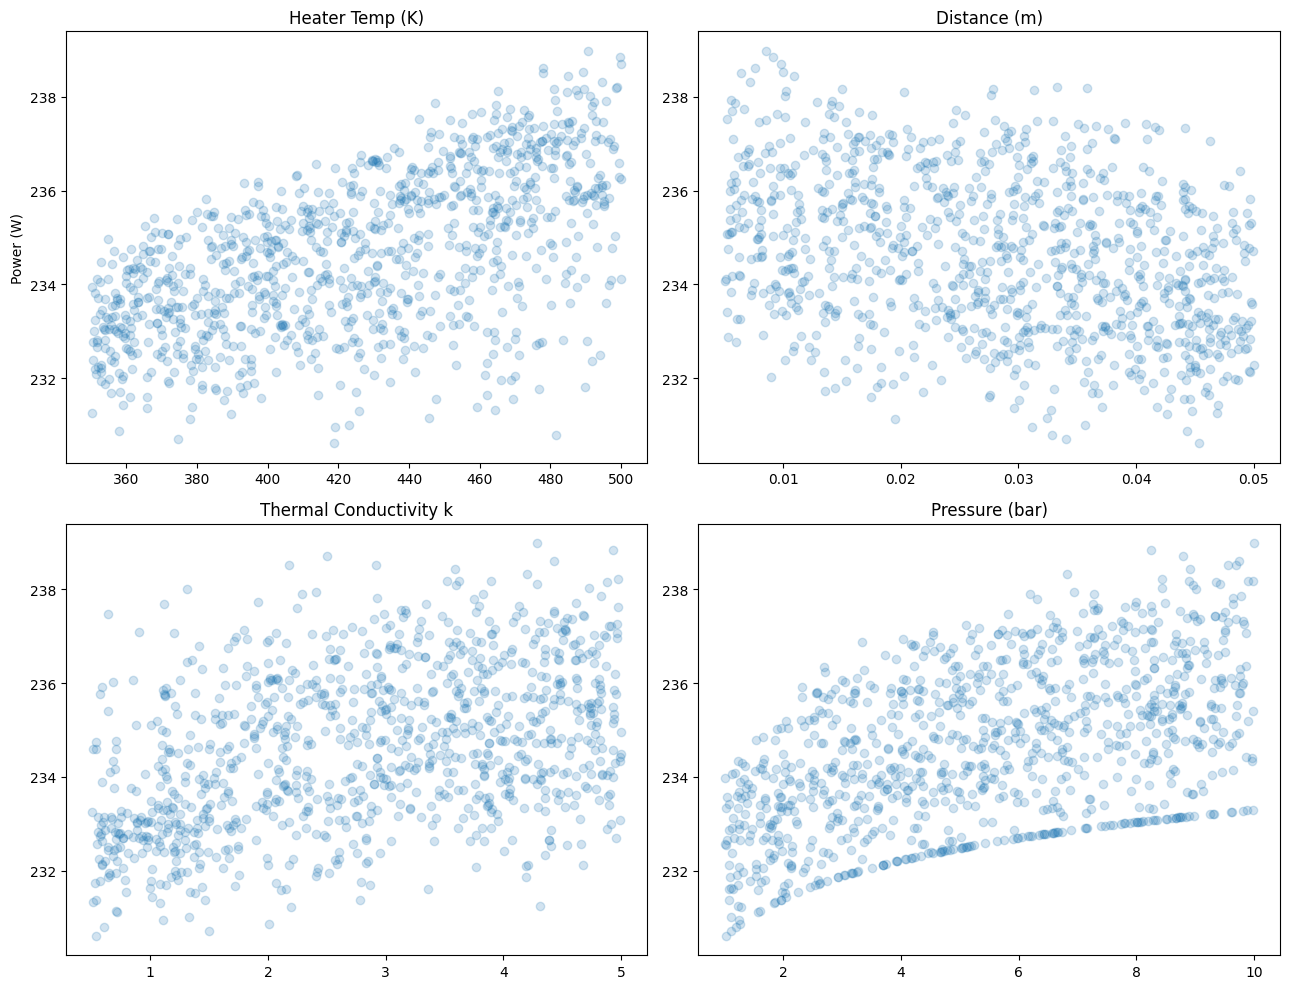

In [23]:
plt.figure(figsize=(13,10))

plt.subplot(221)
plt.scatter(mc_heater_temp, P_out, alpha=0.2)
plt.title("Heater Temp (K)")
plt.ylabel("Power (W)")

plt.subplot(222)
plt.scatter(mc_distance, P_out, alpha=0.2)
plt.title("Distance (m)")


plt.subplot(223)
plt.scatter(mc_k, P_out, alpha=0.2)
plt.title("Thermal Conductivity k")

#plt.subplot(234)
#plt.scatter(mc_h2_flow, P_out, alpha=0.2)
#plt.title("H₂ Flow (kg/s)")
#plt.ylabel("Power (W)")

#plt.subplot(235)
#plt.scatter(mc_o2_flow, P_out, alpha=0.2)
#plt.title("O₂ Flow (kg/s)")

plt.subplot(224)
plt.scatter(mc_pressure, P_out, alpha=0.2)
plt.title("Pressure (bar)")

plt.tight_layout()
plt.show()

In [24]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

morris_problem = {
    'num_vars': 4,
    'names': ['heater_temp', 'distance', 'k', 'pressure'],
    'bounds': [
        [350, 500],       # heater_temp
        [0.005, 0.05],    # distance
        [0.5, 5],         # thermal conductivity
        [1, 10]           # pressure
    ],
    'groups': None
}

num_levels = 4
trajectories = 100  # Number of trajectories, lowered bc took too long
sample = ms.sample(morris_problem, N=trajectories, num_levels=num_levels)

In [25]:
h2_flow_fixed = 1e-7 # Fixed H2/O2 flows
o2_flow_fixed = 8e-5

outputs = []

for params in sample:
    heater_temp, distance, k, pressure = params
    
    results = fuel_cell_outputs(
        heater_temp=heater_temp,
        distance=distance,
        k=k,
        h2_flow=h2_flow_fixed,
        o2_flow=o2_flow_fixed,
        pressure=pressure
    )
    outputs.append(results[3])
outputs = np.array(outputs)

Name                      mu mu_star   sigma
heater_temp             0.15    0.15    0.06
distance             -  0.09    0.09    0.06
k                       0.11    0.11    0.09
pressure                0.16    0.16    0.07


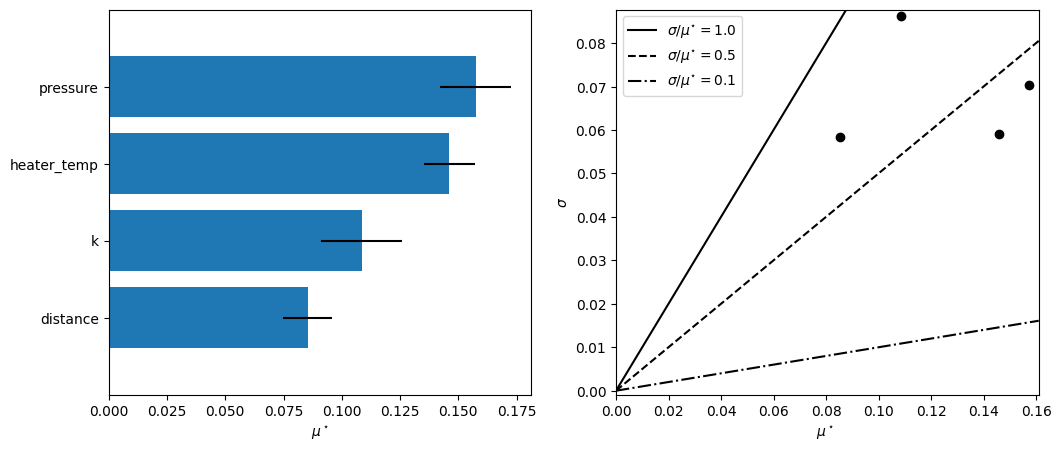

In [26]:
Si = ma.analyze(morris_problem, sample, outputs, num_levels=num_levels, print_to_console=False)

print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], Si['mu'], Si['mu_star'], Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
mp.horizontal_bar_plot(ax1, Si)
mp.covariance_plot(ax2, Si)
plt.show()

Most sensitive are pressure and heater temperature